
# Data Aggregation - Joe Iafrate, July 2017

In [7]:
# run using dev install of EDA:
# github.com/vsihlab/eda
# commit ID: [TODO, downstream from v0.1.1]

In [8]:
# General imports
import json
import pickle

from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

import eda.analysis.dataframe_plotting as dfplot
import eda.data_io.csv_to_dataframe as csv2df

In [9]:
# GLOBAL UNITS: 
# time: ps
# b-field: mT
# voltages: V

# FIGURE DIMENSIONS FOR PRIVATE USE VS REPO:
# FIG_SIZE_MULT = 4  # normal use
FIG_SIZE_MULT = 2.5  # smaller version for repo notebooks

FONT_SCALE = FIG_SIZE_MULT / 2.5

In [10]:
# Optional: import jtplot to make figures match jupyterthemes config
import importlib
jtplot_found = importlib.util.find_spec("jupyterthemes.jtplot") is not None
if jtplot_found:
    from jupyterthemes import jtplot
    # - currently installed theme will be used to
    jtplot.style(ticks=False, grid=False, fscale=FONT_SCALE)
    # set the default figure size
    jtplot.figsize(x=FIG_SIZE_MULT * 2.5, y=FIG_SIZE_MULT * 2.5)
    # needed to avoid spurious error messages with imshow...
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

In [33]:
def display_loaded_data(df, results_df,
                        file_metadata_list, minimize_results,
                        fit_function, residuals_fcn,
                        measured_data_column,
                        independent_vars_columns,
                        x_values_column=None, y_values_column=None,
                        figure_size=None, num_waterfall_plots=None,
                        xlabel=None, ylabel=None, imshow_kwargs=None):
    # plot loaded dataframe and show the first few rows
    if figure_size is None:
        figure_size = (FIG_SIZE_MULT * 3, FIG_SIZE_MULT * 1.5)
    if num_waterfall_plots is None:
        num_waterfall_plots = 4
    if imshow_kwargs is None:
        imshow_kwargs = {'aspect': 1.0,
                         'origin': 'upper'}
    plt.figure(figsize=figure_size)
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    dfplot.plot_dataframe_colorplot(df, measured_data_column,
                                    x_values_column, y_values_column,
                                    xlabel=xlabel, ylabel=ylabel,
                                    ax=ax1, **imshow_kwargs)
    dfplot.plot_dataframe_waterfall(df, measured_data_column,
                                    num_waterfall_plots,
                                    x_values_column, y_values_column,
                                    xlabel=xlabel, ylabel=None, ax=ax2)
    ax2.yaxis.set_ticklabels([])
    plt.show()
    display(df.head(5))
    print('...')
    print('PREPROCESSED FIT RESULTS:')

    # plot fits
    ncols = 4
    nplots = len(minimize_results)
    nrows = np.int(np.ceil(nplots / ncols))
    plt.figure(figsize=(FIG_SIZE_MULT * 3, FIG_SIZE_MULT * nrows))
    for result_index in list(range(nplots)):
        ax = plt.subplot(nrows, ncols, result_index + 1)
        result = minimize_results[result_index]
        dataset_index = results_df.index[result_index]
        xvals = df.loc[dataset_index][x_values_column]
        yvals = df.loc[dataset_index][measured_data_column]
        indep_vars_vecs = [df.loc[dataset_index][colname]
                           for colname in independent_vars_columns]
        fit_yvals = residuals_fcn(result.params, *indep_vars_vecs)
        ax.plot(xvals, yvals, 'bd', label='dataset {}'.format(result_index))
        ax.plot(xvals, fit_yvals, 'r')
        plt.tight_layout()

    # plot params
    params_to_plot_list = result.var_names  # + attributes_to_add
    ncols = 3
    nplots = len(params_to_plot_list)
    nrows = np.int(np.ceil(nplots / ncols))
    plt.figure(figsize=(FIG_SIZE_MULT * 3, FIG_SIZE_MULT * nrows))
    for ind, param in enumerate(params_to_plot_list):
        ax = plt.subplot(nrows, ncols, ind + 1)
        if (param + '_error') in list(results_df):
            ax.errorbar(x=results_df.index.get_level_values(-1),
                        y=results_df[param],
                        yerr=results_df[param + '_error'])
        else:
            ax.plot(results_df.index.get_level_values(-1),
                    results_df[param].values)
        plt.xlabel(results_df.index.names[-1])
        plt.tight_layout()
        plt.title(param)

    # Plot the avg. covariance matrix
    corr_mats = []
    for result in minimize_results:
        covar = result.covar
        oostd = np.diagflat([1.0 / param.stderr
                             for param in list(result.params.values())
                             if param.name in result.var_names
                             if param.stderr != 0])
        corr = np.dot(np.dot(oostd, result.covar), oostd).astype(np.float)
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        corr[mask] = np.nan
        corr_mats.append(corr)
    avgcorr = np.mean(corr_mats, axis=0)
    plt.figure()
    plt.imshow(avgcorr, vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(np.arange(result.nvarys), result.var_names,
               rotation=-35, ha='left')
    plt.yticks(np.arange(result.nvarys), result.var_names)
    plt.title('Avg. correlation matrix, off-diagonal')
    plt.show()

## Load pre-processed data

### Load "july2017_assorted_data/Delay_Scan" (TRKR)

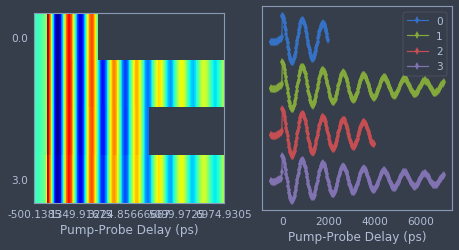

probe_delay   lockin1  kerr_rotation  file_index  \
run_id index_2d index_1d                                                     
0      0.0      0           -500.2216  0.000130       -0.02200           0   
                1           -475.2909  0.000122       -0.02742           0   
                2           -450.3601  0.000088       -0.03182           0   
                3           -425.4294  0.000033       -0.03474           0   
                4           -400.2216  0.000050       -0.03608           0   

                          b_external  wavelength  
run_id index_2d index_1d                          
0      0.0      0              200.0       836.0  
                1              200.0       836.0  
                2              200.0       836.0  
                3              200.0       836.0  
                4              200.0       836.0

...
PREPROCESSED FIT RESULTS:


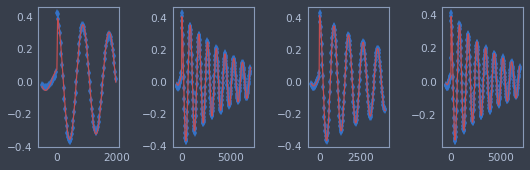

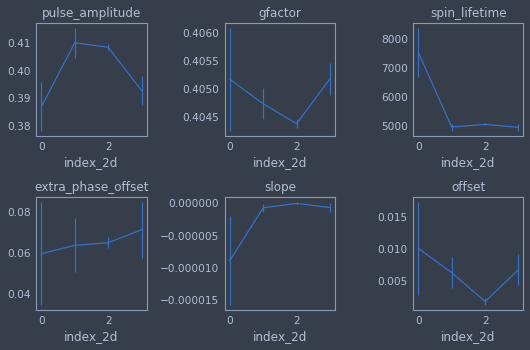

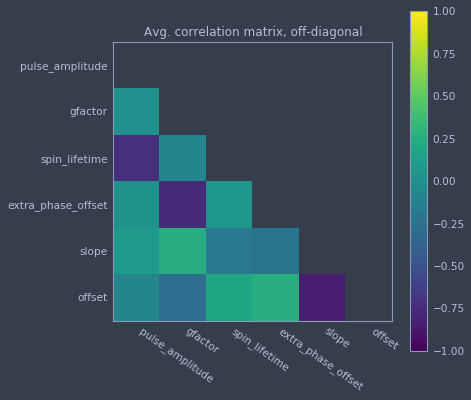

In [36]:
# REQUIRED: columns & labels used to plot data.
trkr_scan_coordinate_column = "probe_delay"
trkr_measured_value_column = "kerr_rotation"
trkr_scan_coordinate_label = "Pump-Probe Delay (ps)"
# optional labels:
trkr_second_coordinate_column = None
trkr_second_coordinate_label = None

# REQUIRED: input filepaths
shared_filepath = ".//example_data//july2017_assorted_data//Delay_Scan//"
dataframe_filepath = \
    shared_filepath + "processed_dataframe.csv"
metadata_list_filepath = \
    shared_filepath + "processed_metadata_list.json"
fit_results_dataframe_filepath = \
    shared_filepath + "fit_results_dataframe.csv"
fit_minimize_results_filepath = \
    shared_filepath + "fit_minimize_results.pickle"

# REQUIRED FOR PRE-FIT DATA: fit function & residuals
from eda.analysis.fit_tools import create_residuals_fcn
from eda.models.simple_dnp_trkr_rsa_simulation \
    import trkr_decaying_cosine

trkr_fit_fcn = trkr_decaying_cosine
trkr_fit_fcn_residuals = \
    create_residuals_fcn(trkr_decaying_cosine,
                         ['delay_time', 'total_bfield'])
# column names corresponding to those indep. variables:
trkr_indep_vars_columns = ["probe_delay", "b_external"]

# load data
with open(dataframe_filepath, 'r') as f:
    trkr_df = pd.read_csv(f, sep='\t',
                          index_col=['run_id', 'index_2d',
                                     'index_1d'])
with open(fit_results_dataframe_filepath, 'r') as f:
    trkr_fit_df = pd.read_csv(f, sep='\t',
                              index_col=['run_id', 'index_2d'])
with open(metadata_list_filepath, 'r') as f:
    trkr_file_metadata_list = json.load(f)
with open(fit_minimize_results_filepath, 'rb') as f:
    trkr_minimize_results = pickle.load(f)

display_loaded_data(trkr_df, trkr_fit_df,
                    trkr_file_metadata_list, trkr_minimize_results,
                    trkr_fit_fcn, trkr_fit_fcn_residuals,
                    trkr_measured_value_column,
                    trkr_indep_vars_columns,
                    x_values_column=trkr_scan_coordinate_column,
                    y_values_column=trkr_second_coordinate_column,
                    figure_size=None, num_waterfall_plots=None,
                    xlabel=trkr_scan_coordinate_label,
                    ylabel=trkr_second_coordinate_label,
                    imshow_kwargs=None)

### Load "july2017_assorted_data/Field_Scan" (RSA)

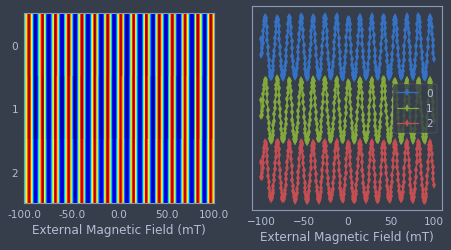

lockin1  kerr_rotation  file_index  probe_delay  \
run_id index_2d index_1d                                                     
0      0.0      0         0.000266        0.01572           0       -160.0   
                1         0.000213       -0.00434           0       -160.0   
                2         0.000274       -0.00180           0       -160.0   
                3         0.000351        0.00418           0       -160.0   
                4         0.000342        0.01082           0       -160.0   

                          wavelength  b_external  
run_id index_2d index_1d                          
0      0.0      0              836.0      -100.0  
                1              836.0       -99.5  
                2              836.0       -99.0  
                3              836.0       -98.5  
                4              836.0       -98.0

...
PREPROCESSED FIT RESULTS:


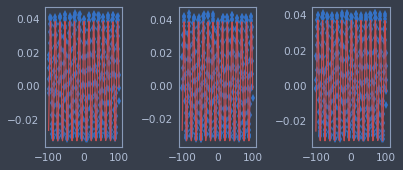

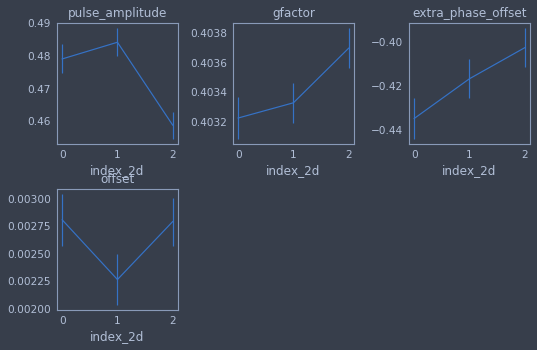

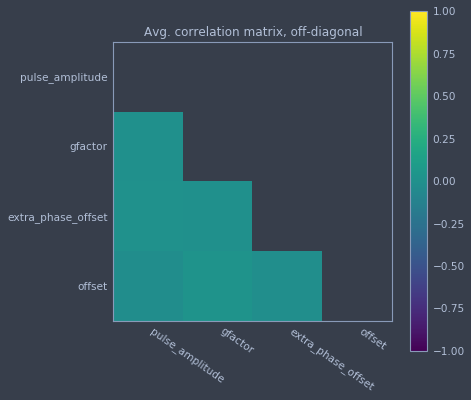

In [41]:
# REQUIRED: columns & labels used to plot data.
rsa_scan_coordinate_column = "b_external"
rsa_measured_value_column = "kerr_rotation"
rsa_scan_coordinate_label = "External Magnetic Field (mT)"
# optional labels:
rsa_second_coordinate_column = None
rsa_second_coordinate_label = None

# REQUIRED: input filepaths
shared_filepath = ".//example_data//july2017_assorted_data//Field_Scan//"
dataframe_filepath = \
    shared_filepath + "processed_dataframe.csv"
metadata_list_filepath = \
    shared_filepath + "processed_metadata_list.json"
fit_results_dataframe_filepath = \
    shared_filepath + "fit_results_dataframe.csv"
fit_minimize_results_filepath = \
    shared_filepath + "fit_minimize_results.pickle"

# REQUIRED FOR PRE-FIT DATA: fit function & residuals
from eda.analysis.fit_tools import create_residuals_fcn
from eda.models.simple_dnp_trkr_rsa_simulation \
    import trkr_decaying_cosine
rsa_fit_fcn = trkr_decaying_cosine
rsa_fit_fcn_residuals = \
    create_residuals_fcn(trkr_decaying_cosine,
                         ['delay_time', 'total_bfield'])
# column names corresponding to those indep. variables:
rsa_indep_vars_columns = ["probe_delay", "b_external"]

# load data
with open(dataframe_filepath, 'r') as f:
    rsa_df = pd.read_csv(f, sep='\t',
                          index_col=['run_id', 'index_2d',
                                     'index_1d'])
with open(fit_results_dataframe_filepath, 'r') as f:
    rsa_fit_df = pd.read_csv(f, sep='\t',
                              index_col=['run_id', 'index_2d'])
with open(metadata_list_filepath, 'r') as f:
    rsa_file_metadata_list = json.load(f)
with open(fit_minimize_results_filepath, 'rb') as f:
    rsa_minimize_results = pickle.load(f)

display_loaded_data(rsa_df, rsa_fit_df,
                    rsa_file_metadata_list, rsa_minimize_results,
                    rsa_fit_fcn, rsa_fit_fcn_residuals,
                    rsa_measured_value_column,
                    rsa_indep_vars_columns,
                    x_values_column=rsa_scan_coordinate_column,
                    y_values_column=rsa_second_coordinate_column,
                    figure_size=None, num_waterfall_plots=None,
                    xlabel=rsa_scan_coordinate_label,
                    ylabel=rsa_second_coordinate_label,
                    imshow_kwargs=None)

### Load "july2017_assorted_data/Mirror_Scan" (Overlap)

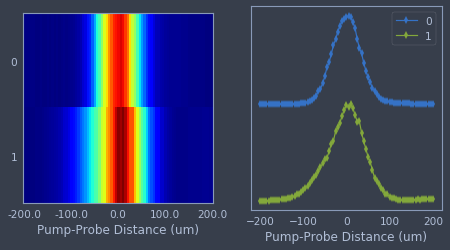

mirror_pos   lockin1  kerr_rotation  file_index  \
run_id index_2d index_1d                                                    
0      11.0     0             -200.0  0.001661        0.00574           0   
                1             -195.0  0.001721        0.00530           0   
                2             -190.0  0.001697        0.00582           0   
                3             -185.0  0.001571        0.00600           0   
                4             -180.0  0.001674        0.00658           0   

                          probe_delay  wavelength  
run_id index_2d index_1d                           
0      11.0     0               100.0       836.0  
                1               100.0       836.0  
                2               100.0       836.0  
                3               100.0       836.0  
                4               100.0       836.0

...
PREPROCESSED FIT RESULTS:


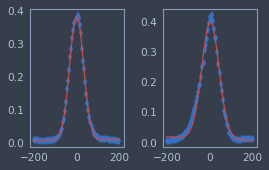

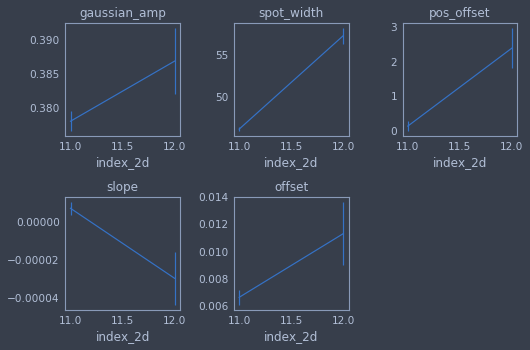

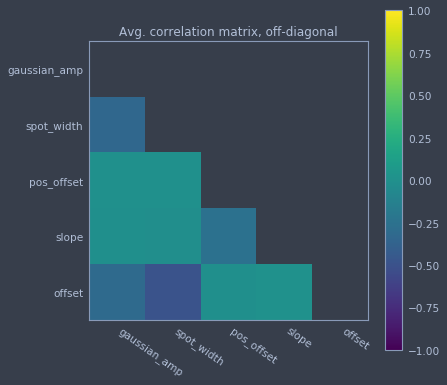

In [46]:
# REQUIRED: columns & labels used to plot data.
overlap_scan_coordinate_column = "mirror_pos"
overlap_measured_value_column = "kerr_rotation"
overlap_scan_coordinate_label = "Pump-Probe Distance (um)"
# optional labels:
overlap_second_coordinate_column = None
overlap_second_coordinate_label = None

# REQUIRED: input filepaths
shared_filepath = ".//example_data//july2017_assorted_data//Mirror_Scan//"
dataframe_filepath = \
    shared_filepath + "processed_dataframe.csv"
metadata_list_filepath = \
    shared_filepath + "processed_metadata_list.json"
fit_results_dataframe_filepath = \
    shared_filepath + "fit_results_dataframe.csv"
fit_minimize_results_filepath = \
    shared_filepath + "fit_minimize_results.pickle"

# REQUIRED FOR PRE-FIT DATA: fit function & residuals
from eda.analysis.fit_tools import create_residuals_fcn

GFACTORCONSTANT = 1.3996e-5  # 1/(ps*mTesla), = bohr magneton/2*pi*hbar
def overlap_fit_fcn(mirror_pos, gaussian_amp, spot_width,
                    pos_offset, slope, offset):
    expo = (0.5 * np.power(mirror_pos - pos_offset, 2)
            / np.power(spot_width / np.sqrt(2), 2))
    output = gaussian_amp * np.exp( -1 * expo)
    output += slope * mirror_pos + offset
    return output

overlap_fit_fcn_residuals = \
    create_residuals_fcn(overlap_fit_fcn, ['mirror_pos'])

# column names corresponding to those indep. variables:
overlap_indep_vars_columns = ['mirror_pos']

# load data
with open(dataframe_filepath, 'r') as f:
    overlap_df = pd.read_csv(f, sep='\t',
                          index_col=['run_id', 'index_2d',
                                     'index_1d'])
with open(fit_results_dataframe_filepath, 'r') as f:
    overlap_fit_df = pd.read_csv(f, sep='\t',
                              index_col=['run_id', 'index_2d'])
with open(metadata_list_filepath, 'r') as f:
    overlap_file_metadata_list = json.load(f)
with open(fit_minimize_results_filepath, 'rb') as f:
    overlap_minimize_results = pickle.load(f)

display_loaded_data(overlap_df, overlap_fit_df,
                    overlap_file_metadata_list, overlap_minimize_results,
                    overlap_fit_fcn, overlap_fit_fcn_residuals,
                    overlap_measured_value_column,
                    overlap_indep_vars_columns,
                    x_values_column=overlap_scan_coordinate_column,
                    y_values_column=overlap_second_coordinate_column,
                    figure_size=None, num_waterfall_plots=None,
                    xlabel=overlap_scan_coordinate_label,
                    ylabel=overlap_second_coordinate_label,
                    imshow_kwargs=None)

### Load "july2017_assorted_data/CISP" (CISP)

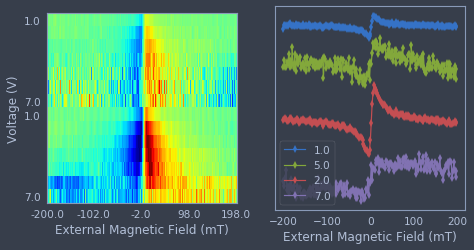

duty_cycle  kerr_rotation  file_index  probe_delay  \
run_id index_2d index_1d                                                       
0      0        0                0.5      -0.310331           0       -160.0   
                1                0.5       0.085397           0       -160.0   
                2                0.5       0.108150           0       -160.0   
                3                0.5       0.032543           0       -160.0   
                4                0.5       0.037324           0       -160.0   

                          wavelength  voltage  b_external  kerr_offset  
run_id index_2d index_1d                                                
0      0        0             836.17      1.0      -200.0    -7.028925  
                1             836.17      1.0      -198.0    -7.028925  
                2             836.17      1.0      -196.0    -7.028925  
                3             836.17      1.0      -194.0    -7.028925  
                4             836.17      1.0      -192.0    -7.028925

...
PREPROCESSED FIT RESULTS:


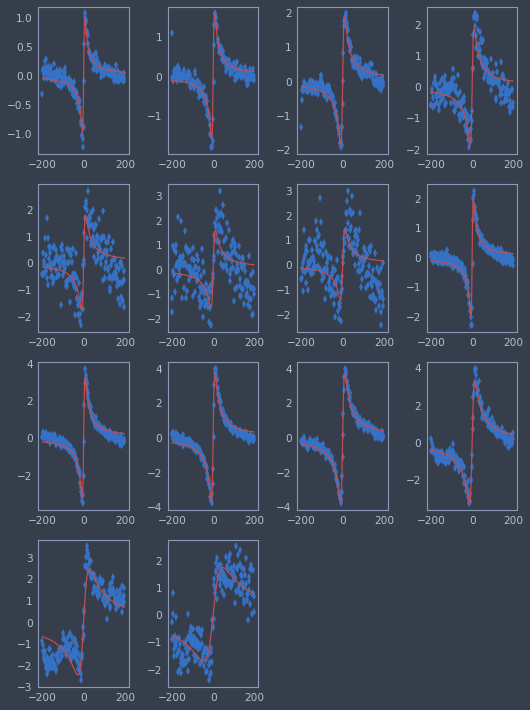

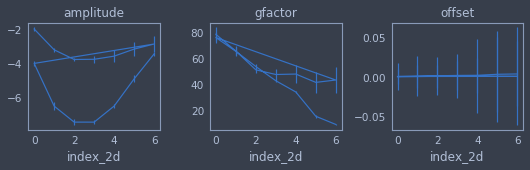

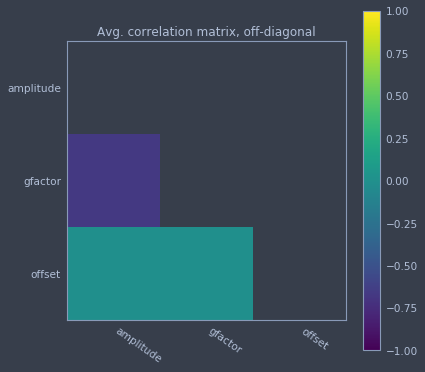

In [45]:
# REQUIRED: columns & labels used to plot data.
CISP_scan_coordinate_column = "b_external"
CISP_measured_value_column = "kerr_rotation"
CISP_scan_coordinate_label = "External Magnetic Field (mT)"
# optional labels:
CISP_second_coordinate_column = "voltage"
CISP_second_coordinate_label = "Voltage (V)"

# REQUIRED: input filepaths
shared_filepath = ".//example_data//july2017_assorted_data//CISP//"
dataframe_filepath = \
    shared_filepath + "processed_dataframe.csv"
metadata_list_filepath = \
    shared_filepath + "processed_metadata_list.json"
fit_results_dataframe_filepath = \
    shared_filepath + "fit_results_dataframe.csv"
fit_minimize_results_filepath = \
    shared_filepath + "fit_minimize_results.pickle"

# REQUIRED FOR PRE-FIT DATA: fit function & residuals
from eda.analysis.fit_tools import create_residuals_fcn

GFACTORCONSTANT = 1.3996e-5  # 1/(ps*mTesla), = bohr magneton/2*pi*hbar
def CISP_fit_fcn(b_external, amplitude, gfactor,
                 delay_time, b_zero_offset,
                 slope, offset):
    offset_b_ext = b_external - b_zero_offset
    x = GFACTORCONSTANT * gfactor * offset_b_ext * delay_time
    output = (amplitude * x / (1 + np.power(x, 2))) + offset
    return output

CISP_fit_fcn_residuals = \
    create_residuals_fcn(CISP_fit_fcn, ['b_external'])

# column names corresponding to those indep. variables:
CISP_indep_vars_columns = ['b_external']

# load data
with open(dataframe_filepath, 'r') as f:
    CISP_df = pd.read_csv(f, sep='\t',
                          index_col=['run_id', 'index_2d',
                                     'index_1d'])
with open(fit_results_dataframe_filepath, 'r') as f:
    CISP_fit_df = pd.read_csv(f, sep='\t',
                              index_col=['run_id', 'index_2d'])
with open(metadata_list_filepath, 'r') as f:
    CISP_file_metadata_list = json.load(f)
with open(fit_minimize_results_filepath, 'rb') as f:
    CISP_minimize_results = pickle.load(f)

display_loaded_data(CISP_df, CISP_fit_df,
                    CISP_file_metadata_list, CISP_minimize_results,
                    CISP_fit_fcn, CISP_fit_fcn_residuals,
                    CISP_measured_value_column,
                    CISP_indep_vars_columns,
                    x_values_column=CISP_scan_coordinate_column,
                    y_values_column=CISP_second_coordinate_column,
                    figure_size=None, num_waterfall_plots=None,
                    xlabel=CISP_scan_coordinate_label,
                    ylabel=CISP_second_coordinate_label,
                    imshow_kwargs=None)